# CRDCDH Semantic Similarity Analysis with Word2Vec by BlazingText



Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.  

SageMaker BlazingText which provides efficient implementations of Word2Vec on

- single CPU instance
- single instance with multiple GPUs - P2 or P3 instances
- multiple CPU instances (Distributed training)

In this notebook, BlazingText is used for distributed training of word2vec using multiple CPU instances.

## Setup

Let's start by specifying:
- The S3 buckets and prefixes that you want to use for saving model data and where training data is located. These should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [1]:
from semantic_similarity_analysis_class import SemanticAnalysis
import common.sagemaker_config as config

# instantiate a class object from SemanticAnalysis and set the sageMaker environment
semantic_analysis = SemanticAnalysis()


sagemaker.config INFO - Not applying SDK defaults from location: /opt/homebrew/share/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/gup2/Library/Application Support/sagemaker/config.yaml
src dir:/Users/gup2/workspace/vscode/crdcdh/crdcdh-ml-notebooks/src
root dir:/Users/gup2/workspace/vscode/crdcdh/crdcdh-ml-notebooks
sagemaker.config INFO - Fetched defaults config from location: /Users/gup2/workspace/vscode/crdcdh/crdcdh-ml-notebooks/configs/sagemaker/config.yaml


Couldn't call 'get_role' to get Role ARN from role name peter.gu to get Role path.


arn:aws:iam::420434175168:role/service-role/AmazonSageMaker-ExecutionRole-20240524T161395


## Training Setup
First of all, set the container.

In [2]:
semantic_analysis.set_container("blazingtext", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


Second, prepare training data

In [3]:
semantic_analysis.prepare_train_data("s3 raw data folder e.g. 2024-06-06-12-12-00")  # transform raw data to training data then upload to s3 bucket

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Training the BlazingText model for generating word vectors

Now let's train the model.

In [4]:
semantic_analysis.train()

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: blazingtext-2024-06-06-23-18-54-956


2024-06-06 23:18:55 Starting - Starting the training job...
2024-06-06 23:19:10 Starting - Preparing the instances for training...
2024-06-06 23:19:34 Downloading - Downloading input data...
2024-06-06 23:20:09 Training - Training image download completed. Training in progress....Arguments: train
[06/06/2024 23:20:19 WARNING 139890804926272] Loggers have already been setup.
[06/06/2024 23:20:19 WARNING 139890804926272] Loggers have already been setup.
/opt/amazon/python3.8/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
[06/06/2024 23:20:20 INFO 139890804926272] nvidia-smi took: 0.025171518325805664 secs to identify 0 gpus
[06/06/2024 23:20:20 INFO 139890804926272] Running single machine CPU BlazingText training using batch_skipgram mode.
Number of CPU sockets found in instance is  1
[06/06/2024 23:20:20 INFO 139890804926272] Processing /opt

### Evaluation

Let us now download the word vectors learned by our model and visualize them using a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) plot.

{
    "EN-WS-353-ALL.txt": {
        "not_found": 2,
        "spearmans_rho": 0.7158456035981258,
        "total_pairs": 353
    },
    "EN-WS-353-REL.txt": {
        "not_found": 1,
        "spearmans_rho": 0.6937718409154603,
        "total_pairs": 252
    },
    "EN-WS-353-SIM.txt": {
        "not_found": 1,
        "spearmans_rho": 0.7244916200696871,
        "total_pairs": 203
    },
    "mean_rho": 0.7113696881944245
}


/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


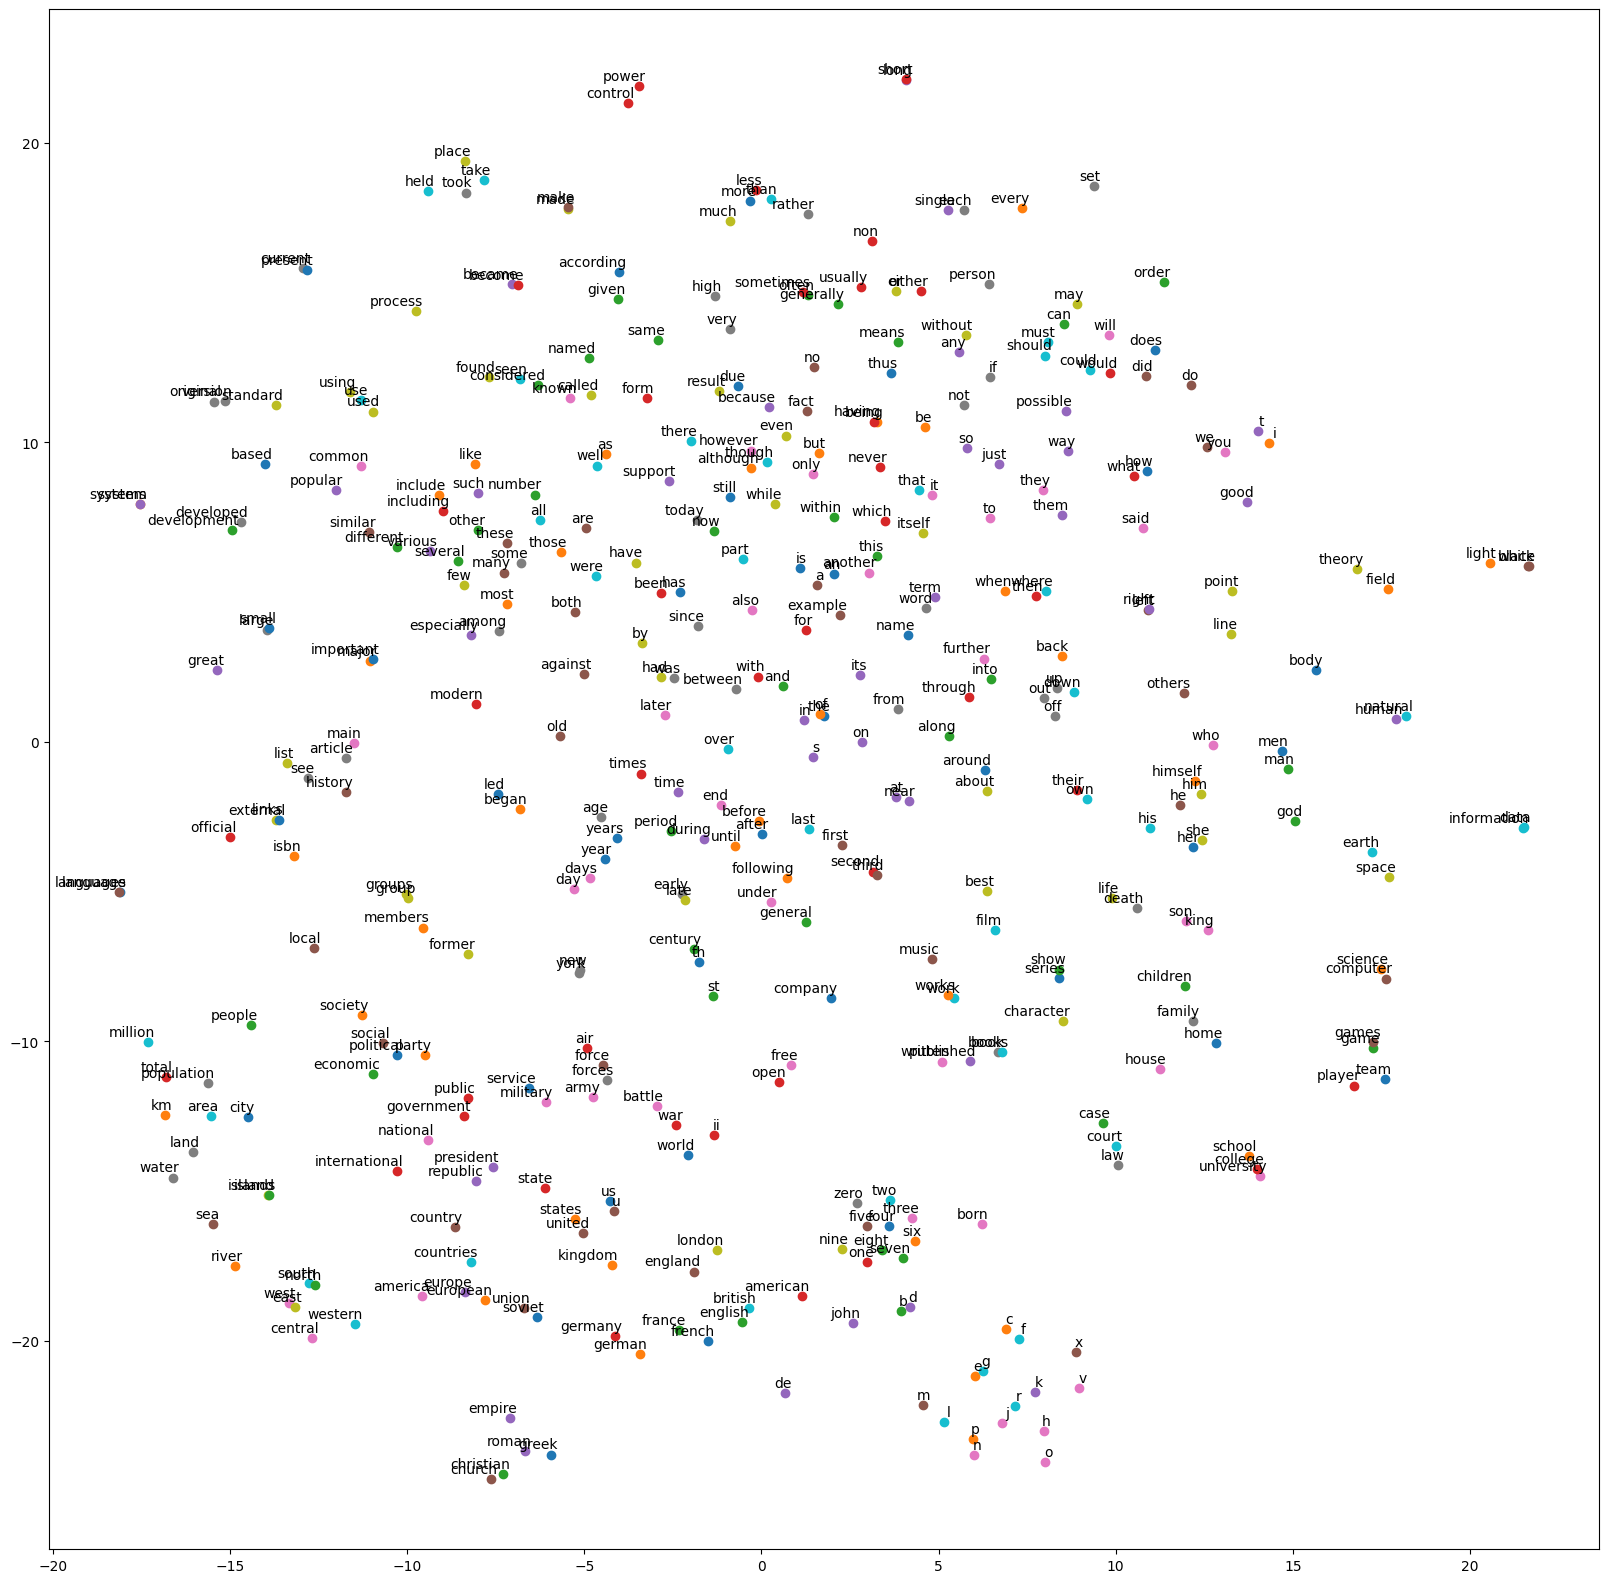

In [5]:
downloaded_model_path = "../output/model.tar.gz"
semantic_analysis.download_trained_model(downloaded_model_path) # download trained model to local
semantic_analysis.evaluate_learned_model_vacs(downloaded_model_path, "../output/model") # evaluate learned vacs in trained model

As expected, we get an n-dimensional vector (where n is vector_dim as specified in hyperparameters) for each of the words. If the word is not there in the training dataset, the model will return a vector of zeros.

Running the code above might generate a plot like the one below. t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look exactly like this, you can still see clusters of similar words such as below where 'british', 'american', 'french', 'english' are near the bottom-left, and 'military', 'army' and 'forces' are all together near the bottom.

![tsne plot of embeddings](../images/tsne.png)

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [6]:
endpoint_name = "crdcdh-ml-loc-endpoint"
semantic_analysis.deploy_trained_model(endpoint_name)

INFO:sagemaker:Creating model with name: blazingtext-2024-06-06-23-22-21-562
INFO:sagemaker:Creating endpoint-config with name crdcdh-ml-loc-endpoint
INFO:sagemaker:Creating endpoint with name crdcdh-ml-loc-endpoint


-----!

### Getting vector representations for words

#### Use JSON format for inference
The payload should contain a list of words with the key as "**instances**". BlazingText supports content-type `application/json`.

[{'vector': [0.36229050159454346, -0.01170111633837223, -0.1200023740530014, -0.0811639353632927, -0.1738770753145218, 0.0637730285525322, -0.2643643915653229, 0.20765303075313568, 0.10567183792591095, 0.24040336906909943, -0.08993165194988251, 0.24802155792713165, -0.3486829996109009, 0.016695711761713028, 0.21028873324394226, 0.10331728309392929, -0.04057992622256279, 0.37807533144950867, 0.1620902717113495, 0.03889255225658417, -0.17778173089027405, -0.010972589254379272, -0.3396775424480438, 0.2513407766819, -0.21993158757686615, 0.2981732487678528, 0.21589723229408264, 0.4744024872779846, -0.0335063636302948, 0.2624474763870239, 0.3393018841743469, -0.04394281655550003, 0.39265844225883484, -0.03317873924970627, -0.3808750808238983, -0.06738442927598953, 0.18072935938835144, -0.19587382674217224, -0.30448827147483826, 0.19098475575447083, 0.05275717377662659, 0.011769823729991913, 0.15484818816184998, -0.05702144652605057, 0.18894898891448975, 0.15437515079975128, 0.02881396934390

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


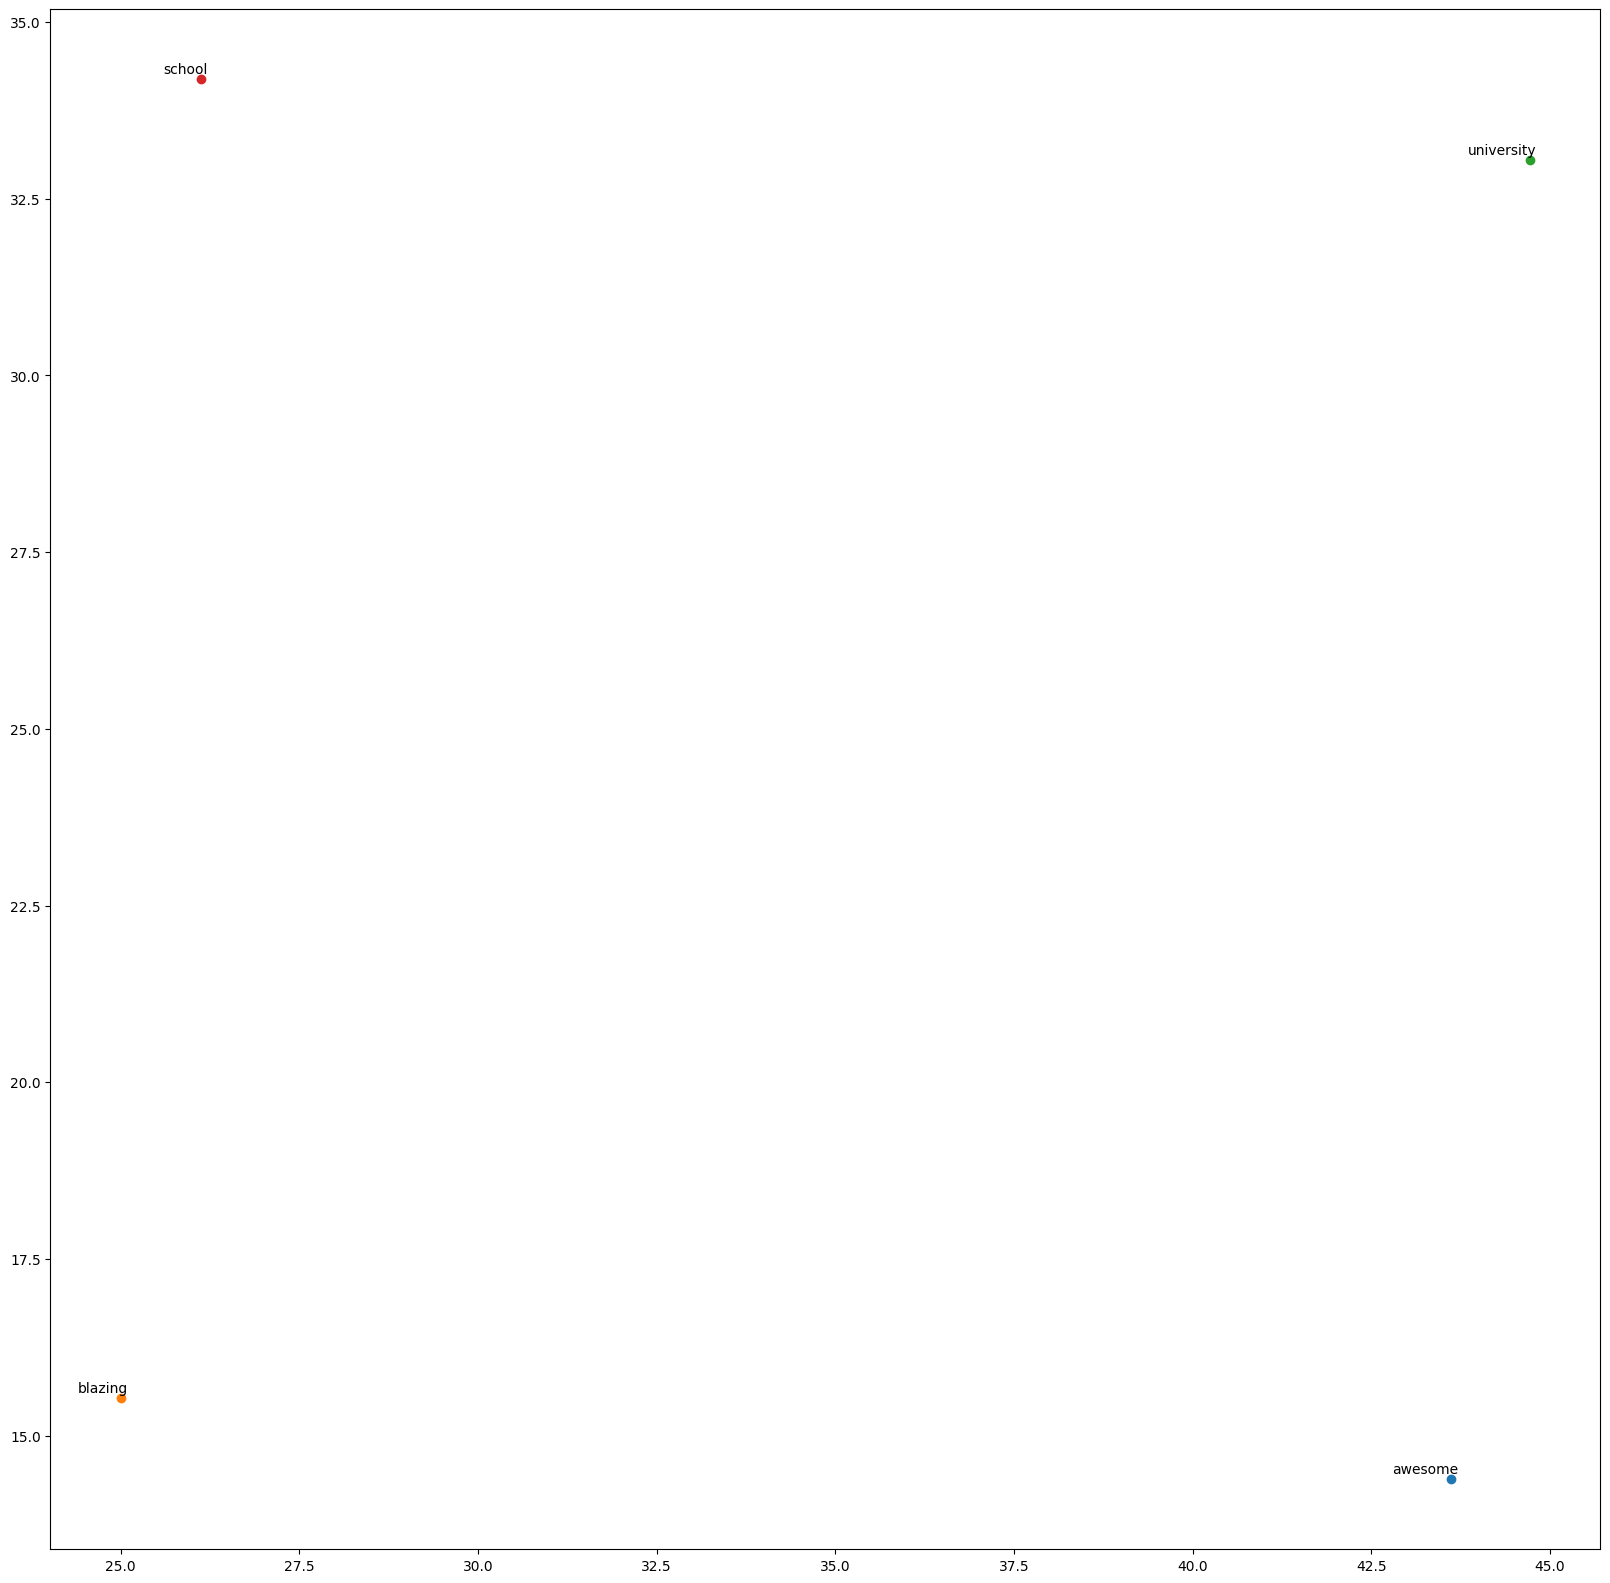

In [7]:
words = ["awesome", "blazing", "university", "school"]
semantic_analysis.evaluate_trained_model(words, "../images")

### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook.

In [8]:
# # Delete the SageMaker endpoint and resources
semantic_analysis.close(endpoint_name)
semantic_analysis = None